In [1]:
import splat
import wisps
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm


%matplotlib inline

Adding 145 sources from /Users/caganze/research/splat//resources/Spectra/Public/LRIS-RED/ to spectral database
Adding 2404 sources from /Users/caganze/research/splat//resources/Spectra/Public/SPEX-PRISM/ to spectral database
Adding 89 sources from /Users/caganze/research/splat//resources/Spectra/Public/MAGE/ to spectral database


In [2]:
#get data 
alld=wisps.get_big_file()
alld=wisps.Annotator.reformat_table(alld)
hst3d_phot=pd.read_csv(wisps.OUTPUT_FILES+'/hst3d_photometry_all.csv')

hst3d_phot.grism_id=hst3d_phot.grism_id.str.lower()
#do a left merge
merged=alld.merge(hst3d_phot[['grism_id', 'flux_radius']], on='grism_id', how='left')


#determine stars based on where they fall based on UCDs
ucds=pd.read_pickle(wisps.LIBRARIES+'/new_real_ucds.pkl')
hucds=ucds[~ucds.grism_id.str.lower().str.startswith('par')]
hucds['flux_radius']=hst3d_phot[hst3d_phot.grism_id.str.lower().isin(ucds.grism_id.str.lower().values)].flux_radius.values

In [3]:
#add appropriate exposure times


In [4]:
#ensure things are saved
assert (merged.shape[0] == alld.shape[0])

In [5]:
#hst3d_phot.dropna()
smldff=hst3d_phot[['Faper160_mag', 'flux_radius']].dropna()
smldff=smldff[np.logical_and.reduce([smldff.Faper160_mag <30., 
                             smldff.Faper160_mag >15., 
                             smldff.flux_radius<10.,
                             smldff.flux_radius>2.])]

In [6]:
smldff['flux_radius'].min()

2.001

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


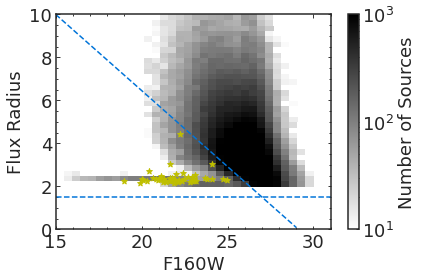

In [7]:
fig, ax=plt.subplots()
#plt.scatter(hst3d_phot['Faper160_mag'],  hst3d_phot['flux_radius'], s=1., alpha=0.1, c='k', marker='+')
h=plt.hist2d(smldff['Faper160_mag'],  smldff['flux_radius'], bins=32, \
             cmap='binary', norm=mpl.colors.LogNorm( vmin=10, vmax=1000))
plt.scatter( hucds['F160W'],  hucds['flux_radius'], c='y', marker='*')

line_cut=np.poly1d(np.polyfit([ 15.0, 27.0], [10.0, 1.5], 1))

plt.plot(np.arange(15, 30.0),line_cut(np.arange(15.0, 30.0)), c='#0074D9', linestyle='--')
plt.axhline(1.5,  c='#0074D9', linestyle='--')

cbar=plt.colorbar(h[3])
cbar.ax.set(ylabel='Number of Sources')
plt.ylim([0., 10.])
plt.xlim([15, 31.])
plt.minorticks_on()
plt.ylabel('Flux Radius')
plt.xlabel('F160W')
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+ '/point_sources_cut.pdf', bbox_inches='tight')

In [8]:
#gfh

In [9]:
bools0= np.logical_and(merged.class_star !=0, merged.grism_id.str.startswith('par')) 
bools1= np.logical_and((~merged.grism_id.str.startswith('par')), (merged.flux_radius_x <  line_cut(merged.F160)))
bools2= merged.flux_radius_x < 1.5
merged['mstar_flag']= np.logical_or.reduce([bools0, bools1, bools2]).astype(int)

In [10]:
merged['flux_radius']=merged['flux_radius_x']
merg=merged.drop(['flux_radius_x', 'flux_radius_y'], axis=1)

In [11]:
#merg.to_hdf(wisps.LIBRARIES+'/master_dataset.h5', key='new')

In [12]:
#merged.mstar_flag

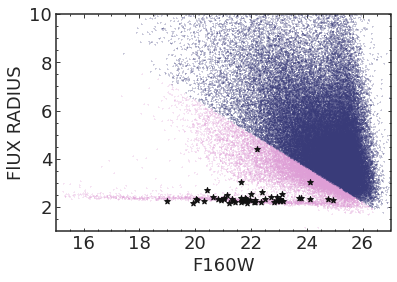

In [13]:
fig, ax=plt.subplots()
plt.scatter(merged['F160'],  merged['flux_radius'], s=1., alpha=0.3,
            c=merged.mstar_flag, marker='+', cmap='tab20b')
plt.scatter( hucds['F160W'],  hucds['flux_radius'], c='#111111', marker='*')

#line_cut=np.poly1d(np.polyfit([ 15.0, 26.0], [10.0, 2.0], 1))

#plt.plot(np.arange(15, 30.0),line_cut(np.arange(15.0, 30.0)), c='b')
plt.ylim([1, 10])
plt.xlim([15, 27])


plt.ylabel('FlUX RADIUS')
plt.xlabel('F160W')
plt.minorticks_on()
#plt.savefig(wisps.OUTPUT_FIGURES+ '/point_sources_cut.pdf', dpi=50000, rasterized=True)

In [14]:
#line_cut

In [15]:
#jhkl

In [16]:
stars=(merged[merged.mstar_flag >0]).reset_index(drop=True)
stars=stars[stars.snr1>=3.0]
cutphot=merged[((merged.snr1>=3.0))]
wispsph=alld[alld.grism_id.str.startswith('par')]
hst3d=alld[~ alld.grism_id.str.startswith('par')]

starswisp=stars[stars.grism_id.str.startswith('par')]
starshst3d=stars[(~ stars.grism_id.str.startswith('par'))]


In [17]:
#https://rmflight.github.io/post/finding-modes-using-kernel-density-estimates/

In [18]:
mag_limits={'wisps':{'F110W':[22.5, 18.0], 'F140W':[22., 16.0], 'F160W':[22.0, 16.0] }, 
            'hst3d':{'F140W':[23., 16.0], 'F160W':[23., 16.0] }}

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


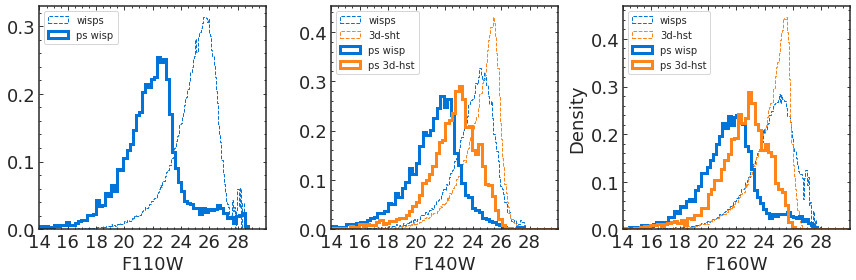

In [19]:
fig, ax=plt.subplots(ncols=3, figsize=(12, 4))
##top
h=ax[2].hist(wispsph.F160.dropna().values, label='wisps', bins='auto', color='#0074D9', density=True, histtype='step', linestyle='--')
h=ax[0].hist(wispsph.F110.dropna().values,  label='wisps', bins='auto', color='#0074D9', density=True, histtype='step', linestyle='--')
h=ax[1].hist(wispsph.F140.replace(np.inf, np.nan).dropna().values,   label='wisps', bins='auto', color='#0074D9', density=True, histtype='step' , linestyle='--')
#h=cutphot.F140.replace(np.inf, np.nan).dropna().plot(kind='hist', ax=ax[0][2], bins='auto',label='F140', color='#7FDBFF', density=True)

h=ax[2].hist(hst3d.F160.dropna().values,  label='3d-hst', bins='auto', color='#FF851B', density=True, histtype='step', linestyle='--')
#h=ax[2].hist(hst3d.F110.dropna().values,  label='3d-hst', bins='auto', color='#2ECC40', density=True, histtype='step',  linestyle='--')
h=ax[1].hist(hst3d.F140.replace(np.inf, np.nan).dropna().values,  label='3d-sht', bins='auto', color='#FF851B', density=True, histtype='step',  linestyle='--')

h=ax[2].hist(starswisp.F160.dropna().values,  label='ps wisp', bins='auto', color='#0074D9', density=True, linewidth=3, histtype='step')
h=ax[0].hist(starswisp.F110.dropna().values,   label='ps wisp', bins='auto', color='#0074D9', density=True, linewidth=3,histtype='step')
h=ax[1].hist(starswisp.F140.replace(np.inf, np.nan).dropna().values,   label='ps wisp', bins='auto',  color='#0074D9', linewidth=3,density=True, histtype='step')

h=ax[2].hist(starshst3d.F160.dropna().values,  label='ps 3d-hst', bins='auto', color='#FF851B', linewidth=3,density=True, histtype='step')
#h=ax[2].hist(starshst3d.F110.dropna().values,   label='ps 3d-hst', bins='auto', color='#111111', density=True, histtype='step')
h=ax[1].hist(starshst3d.F140.replace(np.inf, np.nan).dropna().values,   label='ps 3d-hst', bins='auto', linewidth=3, color='#FF851B', density=True, histtype='step')


#bayesian blocks
#H2 = ax[0][0].hist(cutphot.F160.replace(np.inf, np.nan).dropna(), bins=edgesf160, color='#111111',  density=True, lw =2, histtype='step')
#H2 = ax[0][1].hist(cutphot.F110.replace(np.inf, np.nan).dropna(), bins=edges110, color='#111111',  density=True, lw =2, histtype='step')
#H2 =ax[0][2].hist(cutphot.F140.replace(np.inf, np.nan).dropna(), bins=edges140, color='#111111',  density=True, lw =2, histtype='step')

#ax[0].axvline(mag_limits['wisps']['F140W'][0], color='#B10DC9', linestyle='-')
#ax[0].axvline(mag_limits['hst3d']['F140W'][0], color='#111111', linestyle='-')

#ax[2].axvline(mag_limits['wisps']['F110W'][0], color='#B10DC9', linestyle='-')
#ax[0][1].axvline(23,  color='#111111')


#ax[1].axvline(mag_limits['wisps']['F160W'][0],color='#B10DC9', linestyle='-')
#ax[1].axvline(mag_limits['hst3d']['F160W'][0], color='#111111', linestyle='-')





#ax[1][0].scatter( cutphot.F160, cutphot.exposure, marker=',', alpha=0.1, s=50)
#sns.kdeplot( cutphot.F160, cutphot.exposure, ax=ax[1][0])
#df=cutphot[['F160', 'exposure']].replace(np.inf, np.nan).dropna()
#ax[1][0].hist2d(df.F160.values, df.exposure.values, cmap=wisps.MYCOLORMAP)

#df=cutphot[['F110', 'exposure']].replace(np.inf, np.nan).dropna()
#ax[1][2].hist2d(df.F110.values, df.exposure.values, cmap=wisps.MYCOLORMAP)

#df=cutphot[['F140', 'exposure']].replace(np.inf, np.nan).dropna()
#ax[1][1].hist2d(df.F140.values, df.exposure.values, cmap=wisps.MYCOLORMAP)

#sns.kdeplot( df.F160, df.exposure, ax=ax[1][0], shade=True)
#ax[1][1].scatter( cutphot.F110, cutphot.exposure, marker=',', alpha=0.1, s=50)
#ax[1][2].scatter( cutphot.F140, cutphot.exposure, marker=',', alpha=0.1, s=50)



ax[2].set_xlabel('F160W', fontsize=18)
ax[0].set_xlabel('F110W', fontsize=18)
ax[1].set_xlabel('F140W', fontsize=18)

#ax[1][0].set_ylabel('Exposure (s)', fontsize=18)
ax[2].set_ylabel('Density', fontsize=18)
#ax[1][2].set_ylabel('Exposure (s)', fontsize=18)

for a in ax:
    a.set_xticks(np.arange(14, 30, 2.0))
    a.set_xlim([14, 30])
    a.yaxis.set_ticks_position('both')
    a.xaxis.set_ticks_position('both')
    a.xaxis.set_minor_locator
    #a.tick_params(which='major',direction='inout')
    a.tick_params(which='minor', direction='in')
    #ml = MultipleLocator(.5)
    #a.xaxis.set_minor_locator(ml)
    a.minorticks_on()


#ax[0][0].set_ylim([0., 0.35])
#ax[0][1].set_ylim([0., 0.30])
#ax[0][2].set_ylim([0., 0.35])


ax[0].legend(loc='upper left', fontsize=10)
ax[1].legend(loc='upper left', fontsize=10)
ax[2].legend(loc='upper left', fontsize=10)
    
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/mag_limits_all.pdf', bbox_inches='tight')


In [20]:
ucds=pd.read_pickle('~/research/wisps/libraries/real_ucds.pkl')
ucds['class_star']=alld[alld.grism_id.str.lower().isin(ucds.grism_id.str.lower().values)].class_star.values

In [21]:
wucds=ucds[ucds.grism_id.str.lower().str.startswith('par')]
hucds=ucds[~ucds.grism_id.str.lower().str.startswith('par')]

(0.2, 1.5)

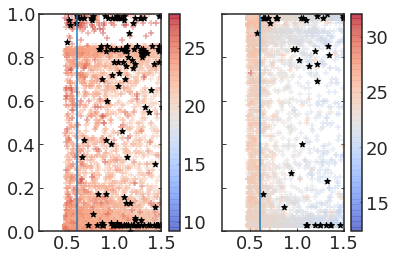

In [22]:
fig, (ax, ax1)=plt.subplots(ncols=2, sharex=True, sharey=True)
cx=ax.scatter(starswisp.snr1.apply(np.log10), starswisp.class_star,
            alpha=.5, marker='+',  c= starswisp.F160, cmap='coolwarm')
        
ax.scatter(wucds.snr1.apply(np.log10), wucds.class_star, marker='*', c='k')
plt.colorbar(cx, ax=ax)
#sns.scatterplot(starswisp.snr1.apply(np.log10), starswisp.snr1.apply(np.log10, s=5, color=".15", ax=ax)
#sns.histplot(x=cutdf.appF140, y=cutdf.snr.apply(np.log10), bins=50, pthresh=.1, cmap="mako")
#sns.kdeplot(starswisp.snr1.apply(np.log10), cutdf.snr.apply(np.log10), levels=5, color="w", linewidths=1)

c=ax1.scatter(starshst3d.snr1.apply(np.log10), starshst3d.class_star, 
            alpha=.5, marker='+', c=starshst3d.F160, cmap='coolwarm')
ax1.scatter(hucds.snr1.apply(np.log10), hucds.class_star, marker='*', c='k')
plt.colorbar(c)
ax.axvline(np.log10(4))
ax1.axvline(np.log10(4))

plt.ylim([0.0, 1.])
#plt.xlabel('')
plt.xlim([0.2, 1.5])

In [23]:
from astropy.io import fits
from astropy.table import Table

In [24]:
#scal=fits.open('https://urldefense.com/v3/__http://homepages.spa.umn.edu/*mscarlat/WISPPhotometricCatalog_v1.2.fits__;fg!!Mih3wA!V4jOw3ITlkzp1jvdGyu3fXDBgLCi8r-HtAKdSNKE66P5ojZq6a8aHNcZOde7Y84$')

In [25]:
#def grism_id(row): return 'par'+ str(int(row.PAR))+'-'+ str(int(row.OBJ)).zfill(5)
#tbl=Table(scal[1].data)
#tbl_df=(tbl['RA', 'DEC', 'PAR','OBJ', 'MAG_AUTO_F140W']).to_pandas()
#tbl_df['grism_id']=tbl_df.apply(grism_id, axis=1)
#merged=tbl_df.merge(fphot, on='grism_id')
#merged.columns
#plt.plot(merged.F140, merged.MAG_AUTO_F140W)

In [26]:
#tbl.columns

In [27]:
#sean_catalog= pd.read_csv(wisps.OUTPUT_FILES+'/wisps_point_sources.csv')

In [28]:

#import glob
#fileo=glob.glob(wisps.REMOTE_FOLDER+'/wisps/archive.stsci.edu/missions/hlsp/wisp/v6.2/'\
#+'par'+str(32)+'/*'+str('f140')+'*_cat.txt')[0]

In [29]:
#!open '/volumes/burgasserlab/Surveys///wisps/archive.stsci.edu/missions/hlsp/wisp/v6.2/par32/hlsp_wisp_hst_wfc3_par32_f140w_v6.2_cat.txt'

In [30]:
#from astropy.io import ascii
#ascii.read(fileo).to_pandas()

In [31]:
#plt.scatter(sean_catalog.half_light_rad, sean_catalog.mag, marker='+')

In [32]:
#s=ucds.spectra[ucds.class_star ==0 ].values[0]

In [33]:
#plt.plot(s.wave, s.flux)
#plt.xlim([1.1,1.7])
#plt.ylim([0.0, 1.])

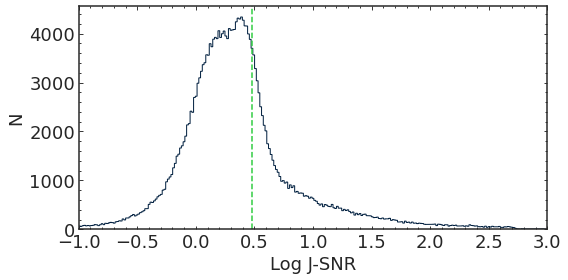

In [34]:
fig, ax1=plt.subplots(figsize=(8, 4), ncols=1, sharey=False)
#h=ax.hist(phot.f_test, bins='auto', color='#001f3f', density=False, histtype='step')

#ax.axvline(.4, color='#2ECC40', linestyle='--')
#ax.set_xlabel('F(x)', fontsize=18)
#ax.set_ylabel('N', fontsize=18)
#ax.minorticks_on()


h=ax1.hist(alld.snr1.apply(np.log10), bins='auto', 
           color='#001f3f', density=False, histtype='step')

ax1.axvline(np.log10(3.), color='#2ECC40', linestyle='--')
ax1.set_xlabel('Log J-SNR', fontsize=18)
ax1.set_ylabel('N', fontsize=18)
ax1.set_xlim([-1., 3.])

ax1.minorticks_on()
plt.tight_layout()

plt.savefig(wisps.OUTPUT_FIGURES+'/f_test_snr_distr.pdf')

In [35]:
import wisps.simulations as wispsim#jk

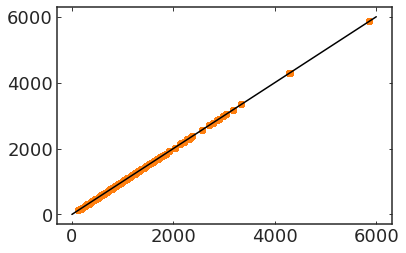

In [36]:
plt.scatter(stars.expt_f140w.values, stars.expt_f110w.values)
plt.scatter(stars.expt_f160w.values, stars.expt_f110w.values)
plt.plot([1, 6000], [1, 6000], c='k')

In [37]:
def get_polynomials(survey):
    exposure_times=[]
    mags=[]
    df=None
    
    if survey=='wisps': df= wisps.Annotator.reformat_table(starswisp)
    if survey=='hst3d': 
        df= wisps.Annotator.reformat_table(starshst3d)
    
    for g in df.groupby('pointing'):
        if len(g[1]) < 50:
            pass
        else:
            exposure_times.append(np.nanmedian(g[1].expt_f140w.values))
            mags.append([wispsim.get_max_value(g[1].F110.values), 
                         wispsim.get_max_value(g[1].F140.values), 
                         wispsim.get_max_value(g[1].F160.values)])
            
    mags=np.vstack(mags)
    if survey=='hst3d': 
        p0=None
    else:
        bools0=np.logical_or.reduce([np.isnan(mags[:, 0]), mags[:,0] <15, mags[:,0] >35])
        _, p0=wisps.fit_with_nsigma_clipping(np.log10(exposure_times)[~bools0], 
                                             mags[:, 0][~bools0], (mags[:, 0]/100)[~bools0], 
                                             sigma=3, n=1)
        
    bools1=np.logical_or.reduce([np.isnan(mags[:, 1]), mags[:,1] <15, mags[:,1] >35])
    bools2=np.logical_or.reduce([np.isnan(mags[:, 2]), mags[:,2] <15, mags[:,2] >35])
    _, p1=wisps.fit_with_nsigma_clipping(np.log10(exposure_times)[~bools1],
                                         mags[:, 1][~bools1], (mags[:, 1]/10)[~bools1], 
                                         sigma=3, n=1)
    _, p2=wisps.fit_with_nsigma_clipping(np.log10(exposure_times)[~bools2], 
                                         mags[:, 2][~bools2], (mags[:, 2]/10)[~bools2],  
                                         sigma=3, n=1)
    if p0 is None:
        sct0=None
    else:
        sct0= np.nanmedian((mags[:,0]-p0(np.log10(exposure_times)))**2)**0.5
    sct1= np.nanmedian((mags[:,1]-p1(np.log10(exposure_times)))**2)**0.5
    sct2= np.nanmedian((mags[:,2]-p2(np.log10(exposure_times)))**2)**0.5
    print (sct0, np.nanstd(mags[:,0]))
    print (sct1, np.nanstd(mags[:,1]))
    print (sct2, np.nanstd(mags[:,2]))
    return {survey: {"F110":(p0, sct0), 
                     "F140": (p1, sct1),
                       "F160":(p2, sct2)}}, [mags,  exposure_times]

In [38]:
wisppol, mags0= get_polynomials('wisps')
hst3dpol, mags1= get_polynomials('hst3d')

0.23360765612209988 0.5038943667884174
0.29135610105223764 0.7495636144809823
0.22849282117355352 1.4165037712823727
None nan
0.14951737583636088 0.24975013181537634
0.14476980642357756 0.2462168836876557


In [39]:
np.nanmedian(mags1[0], axis=0)

array([        nan, 22.50297806, 22.40744171])

In [40]:
expgrid=np.linspace(2, 4.2, 100)

In [41]:
(wisppol['wisps']['F160'][1])

0.22849282117355352

(19.0, 25.0)

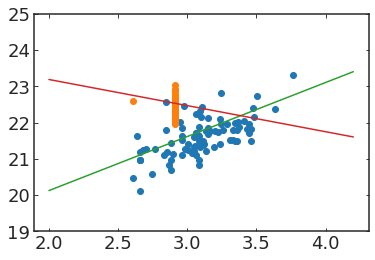

In [42]:
fig, ax=plt.subplots()
plt.plot(np.log10(mags0[1]), mags0[0][:,2], 'o')
plt.plot(np.log10(mags1[1]), mags1[0][:,2], 'o')

plt.plot(expgrid, (wisppol['wisps']['F140'][0])(expgrid))
plt.plot(expgrid, (hst3dpol['hst3d']['F140'][0])(expgrid))
plt.ylim([19, 25])

In [43]:
#fit magnitude uncertainty as a functio
stars= (merg[merg.mstar_flag !=0]).reset_index(drop=True)
mask2=np.logical_or.reduce([np.isnan(stars.F140.values), np.isnan(stars.F140_er.values), 
                           np.abs(stars.F140_er.values)>=2 , stars.F140<15,  stars.F140>30 ])

mask3=np.logical_or.reduce([np.isnan(stars.F160.values), np.isnan(stars.F160_er.values), 
                           np.abs(stars.F160_er.values)>2 , stars.F160<15,  stars.F160>30  ])

mask1=np.logical_or.reduce([np.isnan(stars.F110.values), np.isnan(stars.F110_er.values), 
                           np.abs(stars.F110_er.values)>2 , stars.F110<15,  stars.F110>30  ])

mdata1=stars.F110.values[~mask1]
muncdata1= stars.F110_er.values[~mask1]
tdata1=stars.expt_f140w.values[~mask1]
#snrdata1=stars.exposure_time.values[~mask1]/np.nanmedian(stars.exposure_time.values[~mask1])

mdata2=stars.F140.values[~mask2]
muncdata2= stars.F140_er.values[~mask2]
tdata2=stars.expt_f140w.values[~mask2]

mdata3=stars.F160.values[~mask3]
muncdata3= stars.F160_er.values[~mask3]
tdata3=stars.expt_f140w.values[~mask3]

In [44]:
#bjkl

In [45]:
#!pip install emcee

In [46]:
M0S=[19.6,19.8,18.6]

In [47]:
def fit_snr_exptime(params, snr, ts, mag, m0):
    d, e, f=params
    snrfits= d*(mag-m0)+e*np.log10(ts/1000)+f
    return np.nansum((snrfits-snr)**2)/len(snr)

In [48]:
d0, e0, f0=2.0, 2.0, 1.0
ts=stars.exposure_time.values
snrs=stars.snr1.apply(np.log10).values
mags110= stars.F110.values
mags140= stars.F140.values
mags160= stars.F160.values
mask= np.logical_and.reduce([snrs >=-4, snrs<5, mags110>15, mags110<30])


In [49]:
from scipy.optimize import minimize

In [50]:
res110 = minimize(fit_snr_exptime, [d0, e0, f0], 
               args=(snrs[mask], ts[mask], mags110[mask], M0S[0]),
               method='nelder-mead')
res140 = minimize(fit_snr_exptime, [d0, e0, f0], 
               args=(snrs[mask], ts[mask], mags140[mask], M0S[1]),
               method='nelder-mead')
res160 = minimize(fit_snr_exptime, [d0, e0, f0], 
               args=(snrs[mask], ts[mask], mags160[mask], M0S[-1]),
               method='nelder-mead')
print ('-----error messages -------')
print (res110.message)
print (res140.message)
print (res160.message)

-----error messages -------
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.


In [51]:
tsx=np.random.uniform(np.nanmin(ts), np.nanmax(ts), 100)

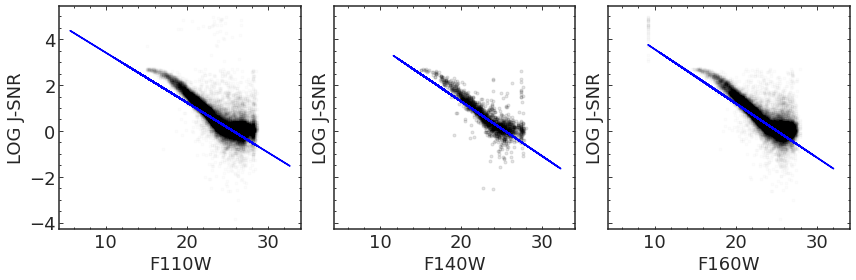

In [52]:
fig, ax=plt.subplots(ncols=3,figsize=(12, 4), sharex=True, sharey=True )

ax[0].plot(mags110[mask], snrs[mask], '.', alpha=0.01, c='k')
ax[1].plot(mags140[mask], snrs[mask], '.', alpha=0.1, c='k')
ax[2].plot(mags160[mask], snrs[mask], '.', alpha=0.01, c='k')

#for t in np.log10(tsx/1000):
ax[0].plot(mags110, res110.x[0]*(mags110-M0S[0])+res110.x[2], c='b', \
           alpha=1.)
ax[1].plot(mags140, res140.x[0]*(mags140-M0S[1])+res140.x[2], c='b', \
           alpha=1.)
ax[2].plot(mags160, res160.x[0]*(mags160-M0S[-1])+res160.x[2], c='b', \
          alpha=1.)
for a in ax:
    a.set_ylabel('LOG J-SNR')
    a.minorticks_on()
    #a.set(xlim=[10, 29],  ylim=[-1, 3.5])
ax[0].set_xlabel('F110W')
ax[1].set_xlabel('F140W')
ax[-1].set_xlabel('F160W')
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/fits_jsnr_mags.jpeg', rasterized=True, bbox_inches='tight')

In [53]:
#jkl

In [54]:
pol={}
pol['mag_limits'] = wisppol
pol['ncutoff']=50
pol['snr_exp']= {'F110':[*res110.x, M0S[0]],
                 'F140': [*res140.x, M0S[1]],
                 'F160': [*res160.x, M0S[-1]]}

In [55]:
#pol

In [56]:
polprv=pd.read_pickle(wisps.OUTPUT_FILES+'/magnitude_cutoff.pkl')

for k in pol.keys():
    polprv[k]=pol[k]

In [57]:
res110.x, res140.x, res160.x

(array([-0.21776493,  0.4024389 ,  1.32173191]),
 array([-0.2388772 ,  0.22807276,  1.32815853]),
 array([-0.23620325,  0.39443396,  1.5334398 ]))

In [58]:
import pickle
output_file=wisps.OUTPUT_FILES+'/magnitude_cutoff.pkl'
with open(output_file, 'wb') as file:
    pickle.dump(polprv,file)

In [59]:
kl

NameError: name 'kl' is not defined

In [ ]:
pnts=pd.read_pickle(wisps.OUTPUT_FILES+'/pointings_correctedf110.pkl')

In [ ]:
mlts=pd.DataFrame([x.mag_limits for x in pnts])
mlts['exp']=[x.imag_exptime for x in pnts]
plt.scatter(mlts.exp, mlts.F140)

In [ ]:
LINE_CUT={'MIN_FLUX':1.5, 'POL': line_cut}

In [ ]:
#import pickle
#output_file=wisps.OUTPUT_FILES+'/line_point_sources_cut.pkl'
#with open(output_file, 'wb') as file:
#    pickle.dump(LINE_CUT,file)

In [ ]:
line_cut

In [ ]:
import  wispsim